# AIE Workshop - Julia for Computational Modelling
## Part 2: Neural networks with `Flux.jl`

- **Speaker**: Fabricio Oliveira 
- **Contact**: fabricio.oliveira@aalto.fi | [gamma-opt.aalto.fi](https://gamma-opt.aalto.fi/)

### Example 1: MNIST

Let's start from a simple example and develop a simple fully connected neural network for predicting digits using the MNIST dataset.

In [23]:
using Flux 
using BSON          # for saving trained model
using MLDatasets    # interface for common ML datasets; BSON is 
using MLUtils       # For data manipulation
using Surrogates    # For sampling

using LinearAlgebra, Random, Statistics, Plots, Images
Random.seed!(1);

This gives us an idea of the sizes of our preset train and test splits.

In [24]:
x_train_raw, y_train_raw = MNIST(split=:train)[:] 
x_test_raw, y_test_raw = MNIST(split=:test)[:]

@show summary(x_train_raw)
@show summary(x_test_raw);

summary(x_train_raw) = "28×28×60000 Array{Float32, 3}"
summary(x_test_raw) = "28×28×10000 Array{Float32, 3}"


Let's have a look at some examples of our data

labels =  [5, 0, 4, 1, 9]


,,,,

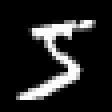
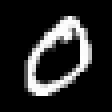
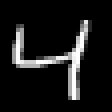
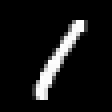
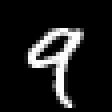

In [25]:
println("labels =  $(y_train_raw[1:5])") 
img = [x_train_raw[:, :, i]' |> colorview(Gray) for i=1:5]  # or use convert2image()

Preparing the data to input our network. Simply means flattening the image to a vector and doing a one-hot encoding of the classes

In [26]:
x_train = Flux.flatten(x_train_raw) # single input layer
x_test = Flux.flatten(x_test_raw)   #

size(x_train) # 28 x 28 = 784

(784, 60000)

In [27]:
y_train = Flux.onehotbatch(y_train_raw, 0:9)
y_test = Flux.onehotbatch(y_test_raw, 0:9)

10×10000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

Now `Flux.jl` really start to show its role. We will startt by defining our model. We choose a very simple fully connected (i.e., `Dense`) network with ReLU activation layers. At the very end, we input a softmax to decide on the classification.

In [28]:
model_MLP = Chain(
    Dense(28 * 28, 32, relu),
    Dense(32, 128, relu),
    Dense(128, 64, relu),
    Dense(64, 10),
    softmax
)

Chain(
  Dense(784 => 32, relu),               # 25_120 parameters
  Dense(32 => 128, relu),               # 4_224 parameters
  Dense(128 => 64, relu),               # 8_256 parameters
  Dense(64 => 10),                      # 650 parameters
  NNlib.softmax,
)                   # Total: 8 arrays, 38_250 parameters, 149.914 KiB.

In `Flux.jl` we have the freedom to define whatever we want as our loss function. Notice we simply used the readly available `Flux.crossentropy`, but we could have defined our own rather trivially.

In [29]:
# sqnorm(x) = sum(abs2, x)
loss(model, x, y) = Flux.crossentropy(model(x), y) #+ sum(sqnorm, Flux.params(model))


# Showcasing equivalence in function definiton while pretting-up things
function calculate_loss(model, data)
    return loss(model, data[1][1], data[1][2])
end

calculate_loss (generic function with 1 method)

Setting up the optimiser to be used in the training. 

In [30]:
η = 0.001 # learning rate
opt = Flux.setup(ADAM(η), model_MLP)

(layers = ((weight = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (weight = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(0.001, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

epoch=1 : train_loss=2.3074534
epoch=11 : train_loss=1.9637378
epoch=21 : train_loss=1.2889465
epoch=31 : train_loss=0.7159186
epoch=41 : train_loss=0.49009284
epoch=51 : train_loss=0.39187136
epoch=61 : train_loss=0.33563712
epoch=71 : train_loss=0.29903296
epoch=81 : train_loss=0.27182177
epoch=91 : train_loss=0.24970347
epoch=101 : train_loss=0.2313164
epoch=111 : train_loss=0.21583642
epoch=121 : train_loss=0.20269036
epoch=131 : train_loss=0.19142236
epoch=141 : train_loss=0.18162185
epoch=151 : train_loss=0.1729085
epoch=161 : train_loss=0.16497281
epoch=171 : train_loss=0.15762262
epoch=181 : train_loss=0.15072712
epoch=191 : train_loss=0.14420491


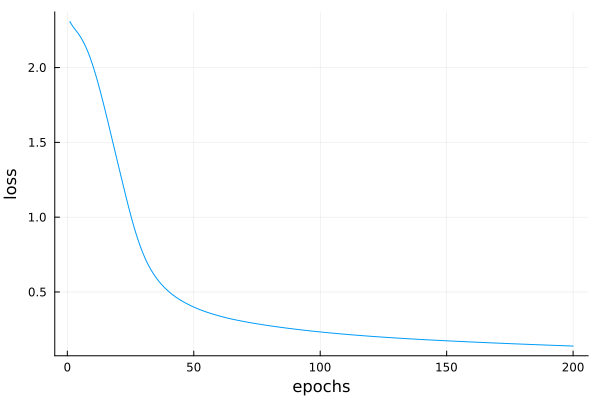

In [31]:
train_data = [(x_train, y_train)]
loss_progression = []
epochs = 200

# Main training loop
for epoch in 1:epochs
   Flux.train!(loss, model_MLP, train_data, opt)  # Tensorflow style training. 
    
    # Logging; you can use @withprogress from ProgressLogging.jl instead  
    l = calculate_loss(model_MLP, train_data)
    push!(loss_progression, l)
    if mod(epoch, 10) == 1  
        println("epoch=$epoch : train_loss=$l")
    end
end

plot(loss_progression, xlabel = "epochs", ylabel = "loss", legend=false)

Let's implement a function to calculate our accuracy on the test set

In [32]:
function calculate_accuracy(model, x, y)
    y_hat = model(x)
    iscorrect = Flux.onecold(y_hat) .== Flux.onecold(y)         # onecold is the inverse of onehot encoding
    return accuracy = round(100 * mean(iscorrect); digits=2)
end

calculate_accuracy(model_MLP, x_test, y_test)

95.32

Let's look as some exemplars in the test set and see how well our model does

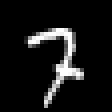

In [33]:
index = 42
img = x_test_raw[:, :, index]' |> colorview(Gray) 

In [34]:
prediction = model_MLP(x_test[:,index])
println("Recognised digit: ", Flux.onecold(prediction, 0:9))
println("Digit label: ", y_test_raw[index])  

Recognised digit: 7
Digit label: 7


## Example 2 - CIFAR10 with CNNs

Let's try something a bit more sophisticated. Our main urpose is to showcase a few more standard yet more advanced features from `Flux.jl`

In [35]:
using MLDatasets: CIFAR10
using .Iterators # Packages from Base have this .

I am using Julia's native `Iterators.jl` to batch my training data into 1000 datapoints batches. If you need more sophisticated data loaders, say due to memory limitations or too large datasets, consider `Flux.DataLoader()`

In [36]:
train_x, train_y = CIFAR10(split=:train)[:]
labels = Flux.onehotbatch(train_y, 0:9)

train_data = ([(train_x[:,:,:,i], labels[:,i]) for i in partition(1:49000, 1000)])

validaton_set = 49001:50000
validation_x = train_x[:,:,:,validaton_set]
validation_y = labels[:, validaton_set]

10×1000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅

Labeled class: (2 => "bird")


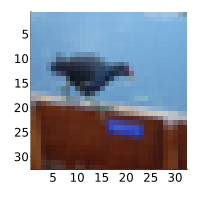

In [37]:
index = rand(1:49000) 
image(x) = colorview(RGB, permutedims(x, (3, 2, 1)))

classes = (
    0 => "airplane",
    1 => "automobile",
    2 => "bird",
    3 => "cat",
    4 => "deer",
    5 => "dog",
    6 => "frog",
    7 => "horse",
    8 => "ship",
    9 => "truck"
)

println("Labeled class: ($(classes[train_y[index] + 1]))")

plot(image(train_x[:,:,:,index]), size = (200,200))


Here is our model. Now we use a few convolution layers before inputting it into a set of dense layers

In [49]:
CNN_model = Chain(
  Conv((5,5), 3=>16, relu),
  MaxPool((2,2)),
  Conv((5,5), 16=>8, relu),
  MaxPool((2,2)),
  x -> reshape(x, :, size(x, 4)),
  Dense(200, 120),
  Dense(120, 84),
  Dense(84, 10),
  softmax)

Chain(
  Conv((5, 5), 3 => 16, relu),          # 1_216 parameters
  MaxPool((2, 2)),
  Conv((5, 5), 16 => 8, relu),          # 3_208 parameters
  MaxPool((2, 2)),
  var"#23#24"(),
  Dense(200 => 120),                    # 24_120 parameters
  Dense(120 => 84),                     # 10_164 parameters
  Dense(84 => 10),                      # 850 parameters
  NNlib.softmax,
)                   # Total: 10 arrays, 39_558 parameters, 155.852 KiB.

Setting up the loss, the optimisation method we will use and an accuracy measure so we can log it during training.

In [50]:
loss(x, y, model) = sum(Flux.crossentropy(model(x), y))
accuracy(x, y, model) = mean(Flux.onecold(model(x), 0:9) .== Flux.onecold(y, 0:9))

accuracy (generic function with 1 method)

In [51]:
using Flux: params, update!

epochs = 15
opt = Momentum(0.01)

# This takes about 1 min per epoch on my 2019 Macbook pro M1
for epoch = 1:epochs
  for d in train_data
    gs = gradient(params(CNN_model)) do # "with respect to"
      l = loss(d..., CNN_model)
    end
    update!(opt, params(CNN_model), gs)
  end
  println("epoch $(epoch) finished. acc.: $(accuracy(validation_x, validation_y, CNN_model))")
end

epoch 1 finished. acc.: 0.177
epoch 2 finished. acc.: 0.317
epoch 3 finished. acc.: 0.407
epoch 4 finished. acc.: 0.427
epoch 5 finished. acc.: 0.414
epoch 6 finished. acc.: 0.468
epoch 7 finished. acc.: 0.475
epoch 8 finished. acc.: 0.487
epoch 9 finished. acc.: 0.49
epoch 10 finished. acc.: 0.491
epoch 11 finished. acc.: 0.512
epoch 12 finished. acc.: 0.505
epoch 13 finished. acc.: 0.511
epoch 14 finished. acc.: 0.509
epoch 15 finished. acc.: 0.492


As this is an expensive task, we don't want to keep doing it. Here is one way we can store our trained model, using Binary JSON (BSON)

In [ ]:
BSON.@save "CNN_model.bson" CNN_model

In [52]:
BSON.@load "CNN_model.bson" CNN_model

In [53]:
test_x, test_y = CIFAR10(split=:test)[:]
test_labels = Flux.onehotbatch(test_y, 0:9)

10×10000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

Predicted class: 6 (6 => "frog")
True class: 6 (6 => "frog")


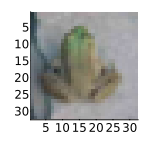

In [56]:
classes = (
    0 => "airplane",
    1 => "automobile",
    2 => "bird",
    3 => "cat",
    4 => "deer",
    5 => "dog",
    6 => "frog",
    7 => "horse",
    8 => "ship",
    9 => "truck"
)

index = rand(1:10000)

rand_test = test_x[:,:,:,[index]] 
rand_truth = test_y[index]
prediction = Flux.onecold(CNN_model(rand_test), 0:9)[1]

println("Predicted class: $(prediction) ($(classes[(prediction) + 1]))")
println("True class: $(rand_truth) ($(classes[(rand_truth) + 1]))")

img = test_x[:,:,:,index]
plot(image(img), size = (150,150))

In [57]:
accuracy(test_x, test_labels, CNN_model)

0.5183

# Example 3 - Inverse optimisation

Let's do something a bit more sophisticated now. Because of Julia's natural function oriented paradigm, we can treat trained NN as functions, and do things such as calculate *gradients*, which we can use in our favour!

Our task will be to try to train a NN that can learn the "shape" of an unknown function. We assume that all we have are inputs and evatuations of this function. 

In [66]:
# Styblinski–Tang function
f(x::Tuple) = 0.5 * sum([xi^4 - 16*xi^2 + 5*xi for xi in x])

num_samples = 1000
lb = Float32[-4.0, -4.0]
ub = Float32[0.0, 0.0]

T2M(x::Vector) = Float32.(reshape(collect(Iterators.flatten(x)), length(x[1]), length(x)))

x_tuple = Surrogates.sample(num_samples, [lb, ub]..., SobolSample())
x = T2M(x_tuple)
y = T2M(f.(x_tuple))

train_data, test_data = splitobs((x, y), at = 0.8) # from MLUtils.jl

# assign the data
x_train, y_train = train_data[1], train_data[2]
x_test, y_test = test_data[1], test_data[2];

Now that our data is in the format we need, let's set p and train a NN that learns the underlying relationship (i.e., function) between the inputs $x$ and outputs $y$. 

We start by building our model and setting its parameterisation

In [73]:
# build the model
surrogate_model = Chain(
    Dense(2, 512, relu),
    Dense(512, 256, relu),
    Dense(256, 1)
)

opt = ADAM()                               # our optimiser
surrogate_loss(model, x, y) = Flux.mse(model(x), y)  # our loss

surrogate_loss (generic function with 2 methods)

In [74]:
loss_progression = []
epochs = 2000

for epoch in 1:epochs
    Flux.train!(surrogate_loss, Flux.params(surrogate_model), [(x_train, y_train)], opt)
    # Logging
    l = loss(surrogate_model, x_train, y_train)
    push!(loss_progression, l)
    if mod(epoch, 10) == 1 || epoch == epochs
        println("epoch=$epoch : train_loss=$l")
    end
end

epoch=1 : train_loss=2228.3506
epoch=11 : train_loss=1705.465
epoch=21 : train_loss=962.1607
epoch=31 : train_loss=244.82469
epoch=41 : train_loss=213.19318
epoch=51 : train_loss=157.73724
epoch=61 : train_loss=155.36476
epoch=71 : train_loss=147.2737
epoch=81 : train_loss=145.88148
epoch=91 : train_loss=143.85736
epoch=101 : train_loss=143.25075
epoch=111 : train_loss=142.38889
epoch=121 : train_loss=141.82391
epoch=131 : train_loss=141.26923
epoch=141 : train_loss=140.69891
epoch=151 : train_loss=140.07866
epoch=161 : train_loss=139.3544
epoch=171 : train_loss=138.4891
epoch=181 : train_loss=137.52074
epoch=191 : train_loss=136.44438
epoch=201 : train_loss=135.24806
epoch=211 : train_loss=133.88477
epoch=221 : train_loss=132.33875
epoch=231 : train_loss=130.75346
epoch=241 : train_loss=129.19208
epoch=251 : train_loss=127.72061
epoch=261 : train_loss=126.38084
epoch=271 : train_loss=125.1976
epoch=281 : train_loss=124.15075
epoch=291 : train_loss=123.229805
epoch=301 : train_loss=122

Let's have a look at our training loss

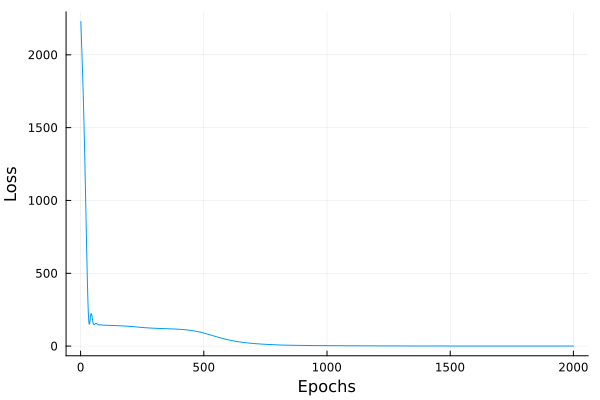

In [75]:
plot(1:epochs, loss_progression,
    xlabel = "Epochs",
    ylabel = "Loss",
    legend = false,
)

And make sure we check for overfitting

In [76]:
test_loss = loss(x_test, y_test)
println("Test Loss = $test_loss")

Test Loss = 0.19720104


Now we are ready to optimise our trained surrogate. Because `model()` can essentially be seen as a function, it also means that we can calculate gradients from it with respect to its inputs!

Let's implement a very simple gradient descent method for the task

In [78]:
x₀ = Float32.([0,0])  
max_iter = 100
θ = 0.01
trajectory = zeros(3, max_iter)

xₖ = x₀
for k =1:max_iter
    ∇ₖ = Flux.jacobian(x -> surrogate_model(x), xₖ)[1] # calculate gradient
    xₖ = xₖ .- θ .* ∇ₖ'
    trajectory[1:2,k] = xₖ
    trajectory[3,k] = surrogate_model(xₖ)[1]
    println("Iteration $k: f(xₖ)=$(surrogate_model(xₖ)[1])")
end

Iteration 1: f(xₖ)=0.11851913
Iteration 2: f(xₖ)=-0.9191593
Iteration 3: f(xₖ)=-1.9807459
Iteration 4: f(xₖ)=-3.0560312
Iteration 5: f(xₖ)=-4.1474113
Iteration 6: f(xₖ)=-5.621552
Iteration 7: f(xₖ)=-7.509507
Iteration 8: f(xₖ)=-9.508217
Iteration 9: f(xₖ)=-11.747406
Iteration 10: f(xₖ)=-14.686207
Iteration 11: f(xₖ)=-18.423748
Iteration 12: f(xₖ)=-24.47996
Iteration 13: f(xₖ)=-31.373322
Iteration 14: f(xₖ)=-39.28461
Iteration 15: f(xₖ)=-46.038536
Iteration 16: f(xₖ)=-52.52013
Iteration 17: f(xₖ)=-58.837467
Iteration 18: f(xₖ)=-64.27678
Iteration 19: f(xₖ)=-68.8736
Iteration 20: f(xₖ)=-72.392334
Iteration 21: f(xₖ)=-74.809746
Iteration 22: f(xₖ)=-76.36584
Iteration 23: f(xₖ)=-77.86553
Iteration 24: f(xₖ)=-78.086235
Iteration 25: f(xₖ)=-78.188484
Iteration 26: f(xₖ)=-78.18964
Iteration 27: f(xₖ)=-78.19081
Iteration 28: f(xₖ)=-78.19197
Iteration 29: f(xₖ)=-78.193146
Iteration 30: f(xₖ)=-78.194275
Iteration 31: f(xₖ)=-78.19544
Iteration 32: f(xₖ)=-78.19661
Iteration 33: f(xₖ)=-78.197754
It

We can see what was the final optimal point and compare against the ground truth, for validation

In [80]:
println("Final optimised position: [$(round(xₖ[1], digits=4)), $(round(xₖ[2], digits=4))]")
println("            Model Output: $(round(surrogate_model(xₖ)[1], digits=4))")
println("  Actual Function Output: $(round(f(Tuple(xₖ)), digits=4))")

Final optimised position: [-2.7375, -2.8544]
            Model Output: -78.2139
  Actual Function Output: -77.8409


Let us visualise how well we are doing

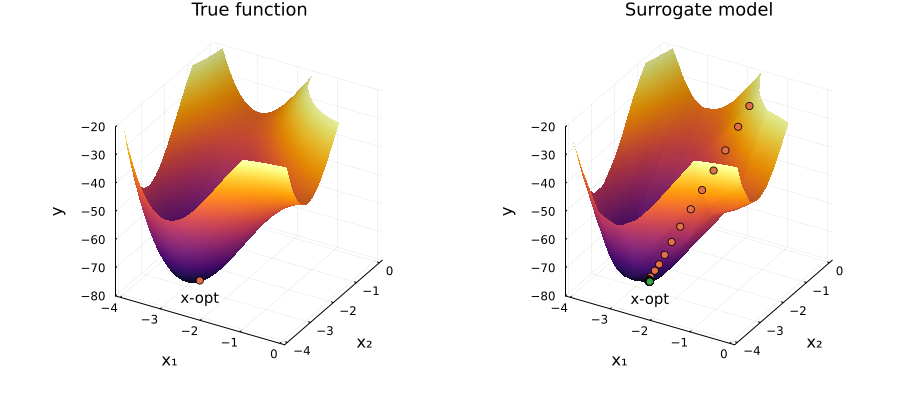

In [81]:
x, y = Float32.(-4.0:0.02:0.0), Float32.(-4.0:0.02:0.0) # To use model() we need Float32
z_true = [f((x1,x2)) for x1 in x, x2 in y]
z_surrogate = [surrogate_model([x1, x2])[1] for x1 in x, x2 in y] 

p1 = surface(x, y, z_true, clims = (-80, -20), colorbar = false)
scatter!(p1, [xₖ[1]], [xₖ[2]], [f(Tuple(xₖ))], legend = false)
annotate!(p1, [(xₖ[1], xₖ[2], f(Tuple(xₖ))-6, text("x-opt", 10))])

p2 = surface(x, y, z_surrogate, clims = (-80, -20), colorbar = false)
scatter!(p2, trajectory[1,:], trajectory[2,:], trajectory[3,:], legend = false)
scatter!(p2, [xₖ[1]], [xₖ[2]], [surrogate_model(xₖ)[1]], legend = false)
annotate!(p2, [(xₖ[1], xₖ[2], surrogate_model(xₖ)[1]-6, text("x-opt", :10))])

plot(p1, p2, 
    title=["True function" "Surrogate model"], 
    titlefontsize = 12,
    zlims = (-80, -20),
    xlabel = ["x₁" "x₁"], ylabel = ["x₂" "x₂"],
    zlabel = ["y" "y"],
    layout=(1,2), 
    size=(900, 400)
)

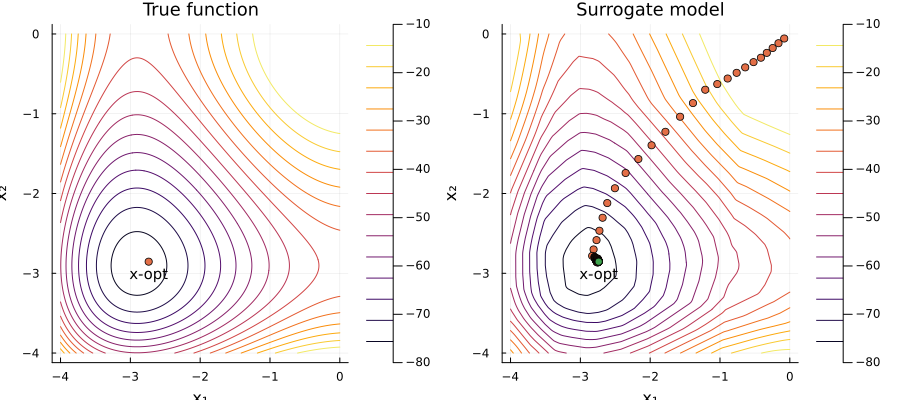

In [82]:
p1 = contour(x, y, z_true, clims = (-80, -10))
scatter!(p1, [xₖ[1]], [xₖ[2]], legend = false)
annotate!(p1, [(xₖ[1], xₖ[2]-0.15, text("x-opt", 10))])

p2 = contour(x, y, z_surrogate, clims = (-80, -10))
scatter!(p2, trajectory[1,:], trajectory[2,:], legend = false)
scatter!(p2, [xₖ[1]], [xₖ[2]], legend = false)
annotate!(p2, [(xₖ[1], xₖ[2]-0.15, text("x-opt", 10))])

plot(p1, p2, 
    title=["True function" "Surrogate model"],
    titlefontsize = 12, 
    xlabel = ["x₁" "x₁"], ylabel = ["x₂" "x₂"],
    layout=(1,2), 
    size=(900, 400),
)